In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.emmental_model import EmmentalModel
from emmental.learner import EmmentalLearner
from emmental.task import Task

### Generate data

In [2]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [3]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

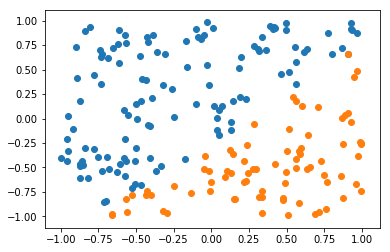

In [4]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

### Create tasks

In [5]:
def mse_loss(immediate_ouput, Y):
    mse = nn.MSELoss()
    return mse(immediate_ouput[-1][0].view(-1), Y.view(-1))

In [6]:
def ce_loss(immediate_ouput, Y):
#     F.cross_entropy(X["data"], Y.view(-1) - 1))
#     ce = nn.BCELoss()
#     print(immediate_ouput[-1][0].size(), Y.size())
    return F.cross_entropy(immediate_ouput[-1][0], Y.view(-1) - 1)

In [7]:
def output(immediate_ouput):
    return immediate_ouput[-1][0]

In [8]:
task1 = Task(
    name="task1",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module1": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module1", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
)

In [9]:
task2 = Task(
    name="task2",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module2": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module2", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
)

In [10]:
mtl_model = EmmentalModel(name = 'all', tasks=[task1, task2])

### Generate dataloader

In [11]:
splits = [0.8, 0.1, 0.1]

X_train, X_dev, X_test = [], [], []
Y_train, Y_dev, Y_test = [], [], []

for i in range(N):
    if i <= N * splits[0]:
        X_train.append(torch.Tensor(X[i]))
        Y_train.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    elif i < N * (splits[0] + splits[1]):
        X_dev.append(torch.Tensor(X[i]))
        Y_dev.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    else:
        X_test.append(torch.Tensor(X[i]))
        Y_test.append(torch.Tensor([Y[i]]).type(torch.LongTensor))

In [12]:
train_dataset = EmmentalDataset({"data": X_train}, {"label": Y_train})
dev_dataset = EmmentalDataset({"data": X_dev}, {"label": Y_dev})
test_dataset = EmmentalDataset({"data": X_test}, {"label": Y_test})

In [13]:
train_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=train_dataset, label_name="label", split="train", batch_size=10
)
dev_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [14]:
train_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=train_dataset, label_name="label", split="train", batch_size=20
)
dev_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

### Load config

In [15]:
from emmental.utils.config import load_config

In [16]:
config = load_config()

In [17]:
config

{'model_config': {'seed': None,
  'verbose': True,
  'device': 'cpu',
  'fp16': False,
  'model_path': None},
 'learner_config': {'seed': None,
  'verbose': True,
  'progress_bar': True,
  'n_epochs': 1,
  'optimizer_config': {'optimizer': 'adam',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None},
  'task_scheduler': 'sequential'},
 'evaluation_config': None,
 'logging_config': {'counter_unit': 'epoch',
  'evaluation_freq': 1.0,
  'checkpointing_freq': 2},
 'writer_config': {'writer': 'tensorboard', 'verbose': True}}

In [18]:
emmental_learner = EmmentalLearner(config)

In [19]:
new_config = {"learner_config": {"n_epochs": 10, "optimizer_config": {"lr": 0.01}}}

In [20]:
emmental_learner.learn(mtl_model, [train_dataloader1, train_dataloader2], config=new_config)

26


In [21]:
for x, y in train_dataloader1:
#     print(x, y)
    res = mtl_model.calculate_probs(x['data'], [train_dataloader1.task_name])
    print(res, res['task1'].shape)

{'task1': array([[  7.5053225,  -8.333671 ],
       [ 12.030731 , -13.306617 ],
       [ -6.757081 ,   7.350455 ],
       [  5.6738157,  -6.338233 ],
       [-11.436083 ,  12.478772 ],
       [-16.511269 ,  18.027344 ],
       [  9.877325 , -10.918387 ],
       [  1.5644051,  -1.83231  ],
       [ -6.181883 ,   6.691979 ],
       [  6.790236 ,  -7.55553  ]], dtype=float32)} (10, 2)
{'task1': array([[  8.7669325,  -9.724367 ],
       [  9.018274 ,  -9.987399 ],
       [  8.236512 ,  -9.146617 ],
       [  5.398513 ,  -5.9780436],
       [  7.3742504,  -8.197651 ],
       [  9.552507 , -10.587149 ],
       [  3.6857576,  -4.117903 ],
       [-10.359005 ,  11.2877445],
       [ -6.9161177,   7.495649 ],
       [  1.3125783,  -1.5481138]], dtype=float32)} (10, 2)
{'task1': array([[ 10.849951  , -11.992295  ],
       [-16.427     ,  17.93314   ],
       [  1.4931718 ,  -1.738659  ],
       [  0.24991822,  -0.38699305],
       [ -1.5279857 ,   1.5607244 ],
       [-16.310162  ,  17.804127  ]

In [22]:
mtl_model.predict(train_dataloader1, retrun_preds=True)

(defaultdict(list,
             {'task1': [array([1]),
               array([1]),
               array([2]),
               array([1]),
               array([2]),
               array([2]),
               array([1]),
               array([1]),
               array([2]),
               array([1]),
               array([1]),
               array([1]),
               array([1]),
               array([1]),
               array([1]),
               array([1]),
               array([1]),
               array([2]),
               array([2]),
               array([1]),
               array([1]),
               array([2]),
               array([1]),
               array([2]),
               array([2]),
               array([2]),
               array([1]),
               array([2]),
               array([2]),
               array([1]),
               array([2]),
               array([1]),
               array([1]),
               array([1]),
               array([2]),
               array([1]),
